In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import copy
import cv2

import sys

import os

from game.flappy_bird import GameState
import math
from matplotlib.pyplot import imshow

pygame 2.0.3 (SDL 2.0.16, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
images=[]
processed_images=[]
ACTION_NUM = 2

class DQN(nn.Module):

    def __init__(self):
        '''
        output size: (((W - K + 2P)/S) + 1)
        Here W = Input size
        K = Filter size
        S = Stride
        P = Padding 
        '''
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(inplace=True))
        self.fc1 = nn.Sequential(nn.Linear(7 * 7 * 64, 512), nn.ReLU(inplace=True))
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
def preprocess_image(image):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    image = cv2.flip(image,1)
    
    # remove ground
    image = image[:400,:]
    
    # resize image
    image = cv2.resize(image, (84, 84))
    
    # convert image to grayscale
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    retval, image = cv2.threshold(image, 158, 255, cv2.THRESH_BINARY)
    
    # convert image data to desire tensor shape
    image = torch.FloatTensor(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    
    return image

class MasterBird:
    def __init__(self, action_num, model):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model = model
        self.model = self.model.to(device)
        self.action_num = action_num

    # demo predict function
    def play_action(self, state):
        # get q values for the state from DQN model
        q_values = self.model(state)[0]
        action_index = torch.argmax(q_values).cpu().numpy().tolist()
        return action_index, q_values
    
def GetSomeStateImages(model):
    # instantiate game
    game_state = GameState()
    masterBird = MasterBird(ACTION_NUM, model)

    # initial action is do nothing
    action = torch.zeros([ACTION_NUM], dtype=torch.float32)
    action[0] = 1
    state_image, reward, terminal, state_score = game_state.frame_step(action)
    image = preprocess_image(state_image)
    state = torch.cat((image, image, image, image)).unsqueeze(0)

    for i in range(200):
        action_idx, q_values = masterBird.play_action(state)
        action = torch.zeros([ACTION_NUM], dtype=torch.float32)
        action[action_idx] = 1
        
        # get next state
        state_image_1, reward, terminal, state_score = game_state.frame_step(action)
        images.append(state_image_1)
        image_1 = preprocess_image(state_image_1)
        processed_images.append(image_1)
        state_1 = torch.cat((state.squeeze(0)[1:, :, :], image_1)).unsqueeze(0)
        
        # set state to be state_1
        state = state_1

In [3]:
def rotate_image(image):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    image = cv2.flip(image,1)
    return image

def preprocess_image_test(image):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    image = cv2.flip(image,1)
    
    # remove ground
    image = image[:400,:]
    
    # resize image
    image = cv2.resize(image, (84, 84))
    
    # convert image to grayscale
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    retval, image = cv2.threshold(image, 158, 255, cv2.THRESH_BINARY)

    return image


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = torch.load('pretrained_model/color_ez_model_4000000_2021-11-23_181113.pth', map_location='cpu').eval()
model.to(device)

GetSomeStateImages(model)

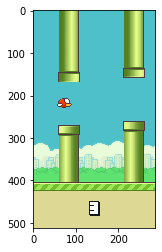

In [5]:
image_1 = rotate_image(images[165])
imshow(image_1)

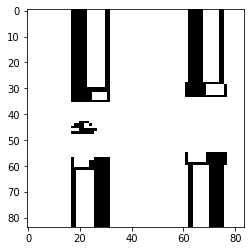

In [6]:
image_1_processed = preprocess_image_test(images[165])
imshow(image_1_processed, cmap='gray')

In [23]:
def preprocess_image_test2(image):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    image = cv2.flip(image,1)
    
    # remove ground
    image = image[:400,:]
    
    # resize image
    image = cv2.resize(image, (84, 84))

    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return image

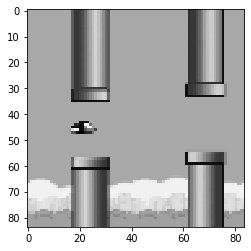

In [25]:
image_1_processed2 = preprocess_image_test2(images[165])
imshow(image_1_processed2, cmap='gray')